In [9]:
import os
import sys
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
sys.path.append(os.path.join(os.getcwd(), 'common'))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.1
np.random.seed(seed=123)

# image = cv2.imread(img_path, 0)

In [10]:
def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct,axis=1, norm='ortho'),axis=0, norm='ortho'))#NEED to convert to integeger, because we would be able to plot with real and complex number

    return mark, watermarked


# mark, watermarked = embedding(image, N, alpha, v)
# cv2.imwrite('watermarked.bmp', watermarked)

In [11]:
def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  csf = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(csf,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

# Plot the two images side by side
# plt.figure(figsize=(15, 6))
# plt.subplot(121)
# plt.title('Original')
# plt.imshow(image, cmap='gray')
# plt.subplot(122)
# plt.title('Watermarked')
# plt.imshow(watermarked,cmap='gray')
# plt.show()

# Compute quality
# psnr = cv2.PSNR(image, watermarked)
# print('PSNR: %.2fdB' % psnr)
# w = wpsnr(image, watermarked)
# print('wPSNR: %.2fdB' % w)


In [12]:
def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations[1:mark_size+1]):
        if v=='additive':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) /alpha
        elif v=='multiplicative':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) / (alpha*ori_dct[loc])
            
    return w_ex

# w_ex = detection(image, watermarked, alpha, N, v)

In [13]:
def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def compute_thr(sim, mark_size, w):
    SIM = np.zeros(1000)
    for i in range(1, 1000):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('threshold: ', T)
    return T

# sim = similarity(mark, w_ex)
# T = compute_thr(sim, N, mark)

# if sim > T:
#     print('Mark has been found. SIM = %f' % sim)
# else:
#     print('Mark has been lost. SIM = %f' % sim)

## PIPELINE

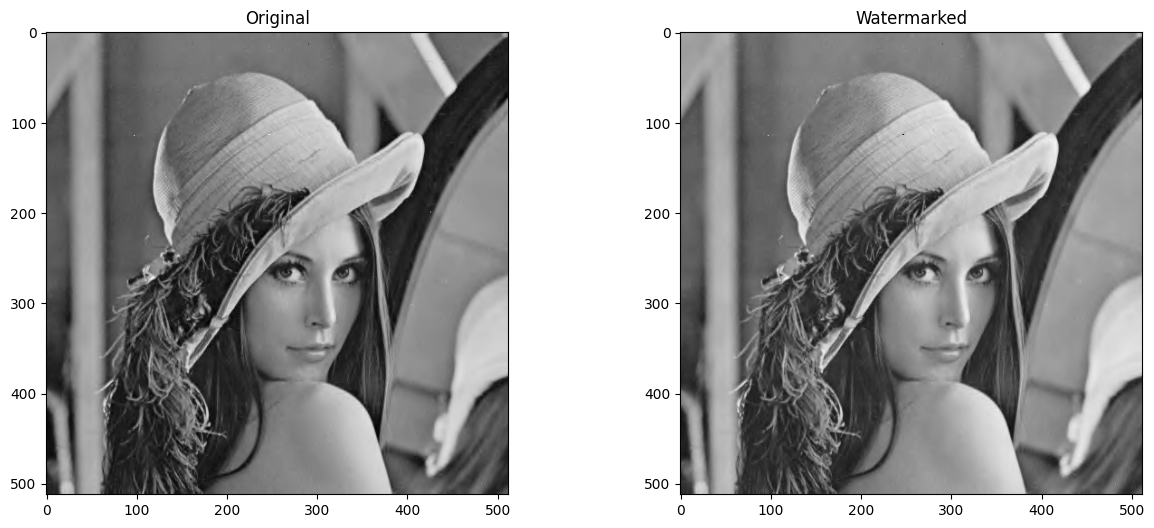

PSNR: 37.65dB
wPSNR: 44.20dB
threshold:  0.7155977263270926
Mark has been found. SIM = 0.997930


In [14]:


# load the image
image = cv2.imread(img_path, 0)

#Embed the watermark and save it
mark, watermarked = embedding(image, N, alpha, v)

#plot the original and watermarked image
cv2.imwrite('watermarked.bmp', watermarked)
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarked,cmap='gray')
plt.show()

#check the quality of the watermarked image with respect to the original image
psnr = cv2.PSNR(image, watermarked)
print('PSNR: %.2fdB' % psnr)
w = wpsnr(image, watermarked)
print('wPSNR: %.2fdB' % w)


#Detect the watermark
w_ex = detection(image, watermarked, alpha, N, v)

#Compute the similarity and threshold
sim = similarity(mark, w_ex)
T = compute_thr(sim, N, mark)

if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)

## Attack

In [16]:

import importlib
import attacks 
from detection import detection, similarity

# Reload the entirea module, not the function
importlib.reload(attacks)

(history, best) = attacks.multiple_attacks(watermarked)
# print("history")
# print(history)




Applying AWGN:   0%|          | 0/6 [00:00<?, ?it/s]   

Applying JPEG Compression: 100%|██████████| 6/6 [00:14<00:00,  2.42s/it]

Best attack: JPEG Compression, PSNR: 38.25543938061093, WPSNR: 53.3482697244228, Params: QF: 57


In [17]:
alpha = 1.7
mark = np.load('ammhackati.npy')
for attack_name,attack in history.items():
    for attacked_image in attack:
        print("Attack: ", attacked_image['attacked_image'].shape,image.shape)
        w_ex = detection(image, attacked_image['attacked_image'], alpha)
        for w in w_ex:

            sim = similarity(mark, w)
            if sim > T:
                print('Mark has been found. SIM = %f' % sim)
                print("Attack: ", attack_name)
            else:
                print('Mark has been lost. SIM = %f' % sim)
                print("Attack: ", attack_name)

Attack:  (512, 512) (512, 512)


TypeError: 'NoneType' object is not iterable

In [46]:
import pywt


def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask = compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband,axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            x = locations[idx][0]
            y = locations[idx][1]
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            x = locations[idx][0]
            y = locations[idx][1]
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
    
    return sign, watermarked

def recursive_embedding(coeffs, mark, alpha, level, max_level, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach level 3, embed the watermark and return
    if level == max_level:
        sign_LH, watermarked_LH = embed_watermark(LH, mark, level, 0, alpha, v)
        sign_HL, watermarked_HL = embed_watermark(HL, mark, level, 1, alpha, v)
        sign_HH, watermarked_HH = embed_watermark(HH, mark, level, 2, alpha, v)

        # Apply the sign and return the inverse DWT
        watermarked_LH *= sign_LH
        watermarked_HL *= sign_HL
        watermarked_HH *= sign_HH

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, level + 1, max_level, v)

    # Embed the watermark at this level
    sign_LH, watermarked_LH = embed_watermark(LH, mark, level, 0, alpha, v)
    sign_HL, watermarked_HL = embed_watermark(HL, mark, level, 1, alpha, v)
    sign_HH, watermarked_HH = embed_watermark(HH, mark, level, 2, alpha, v)

    # Apply the sign to the watermarked coefficients
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_level=2, v='multiplicative'):
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')
    
    # Start recursive embedding from level 0
    watermarked_image = recursive_embedding(coeffs, mark, alpha, level=0, max_level=max_level, v=v)
    
    return watermarked_image

alpha = 1.7
wm = embedding(image, mark, alpha)

from utility import visualize_images_with_desc
visualize_images_with_desc([image, wm], ['Original', 'Watermarked'])





In [20]:
import importlib
import attacks as attacks
from detection import detection, similarity

# Reload the entire module, not the function
importlib.reload(attacks)

(history, best) = attacks.multiple_attacks(wm)

Applying JPEG Compression: 100%|██████████| 6/6 [00:13<00:00,  2.27s/it]

Best attack: AWGN, PSNR: 46.937785294948426, WPSNR: 58.76737609326062, Params: std: 1


In [41]:
# alpha = 1.7
# mark = np.load('ammhackati.npy')
# for attack_name,attack in history.items():
#     for attacked_image in attack:
#         print("Attack: ", attacked_image['attacked_image'].shape,image.shape)
#         w_ex = detection(image, attacked_image['attacked_image'], alpha)
#         for w in w_ex:

#             sim = similarity(mark, w)
#             if sim > T:
#                 print('Mark has been found. SIM = %f' % sim)
#                 print("Attack: ", attack_name)
#             else:
#                 print('Mark has been lost. SIM = %f' % sim)
#                 print("Attack: ", attack_name)

Attack:  (512, 512) (512, 512)


ValueError: operands could not be broadcast together with shapes (1024,) (1023,) 

Applying JPEG Compression: 100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


Best attack: JPEG Compression, PSNR: 41.71730604026793, WPSNR: 59.755802249643395, Params: QF: 81
{'mean_psnr': 24.727436036076583, 'mean_wpsnr': 34.70058878119204, 'best_wpsnr': 59.755802249643395, 'worst_wpsnr': 11.652951278477603}


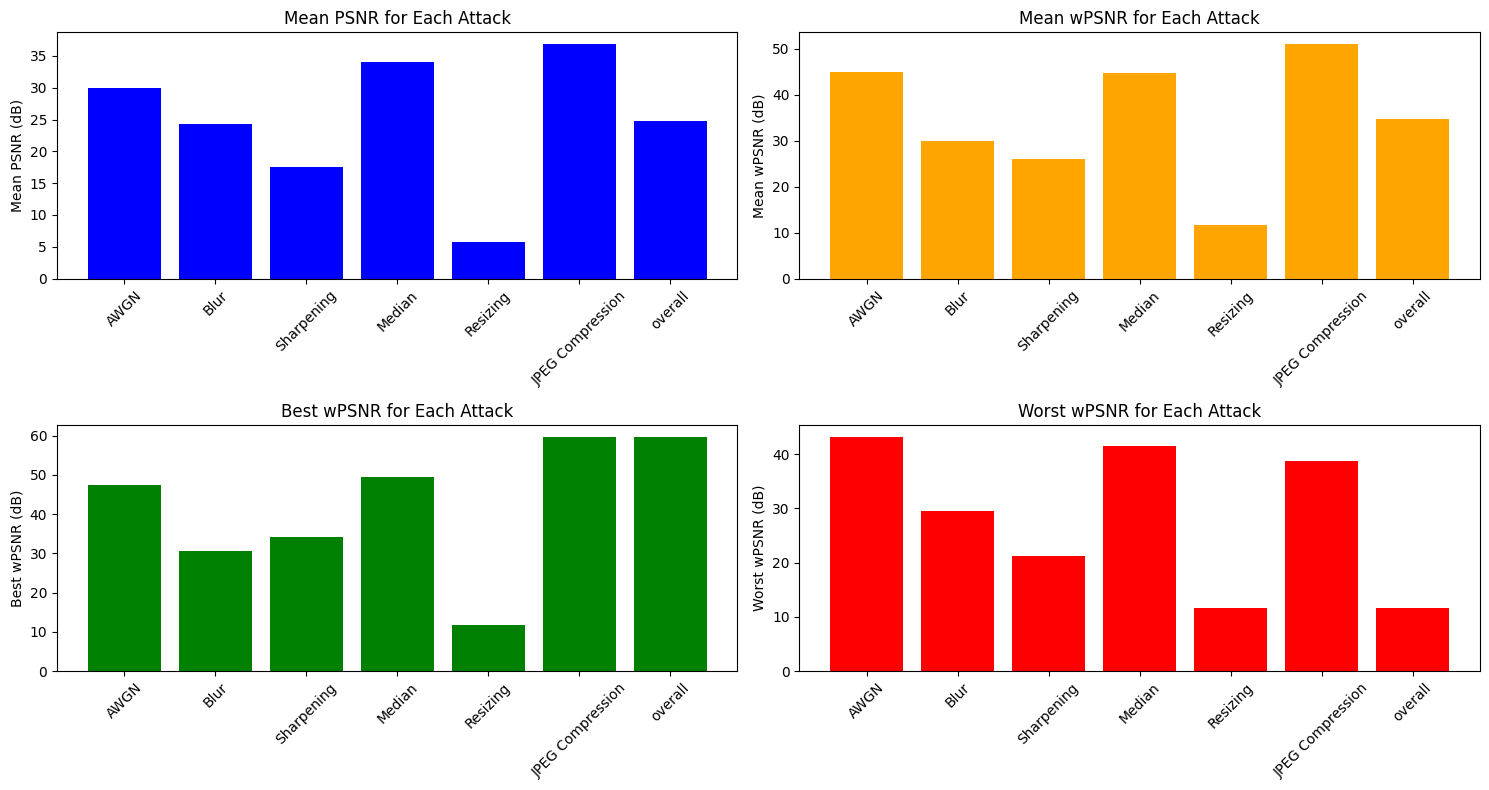

In [21]:


# Reload the entire module, not the function
importlib.reload(attacks)

(history,_) = attacks.multiple_attacks(wm)
#print(history)
stats = attacks.stats(history)
print(stats['overall'])
attacks.plot_stats(stats)

# FULL PIPELINE

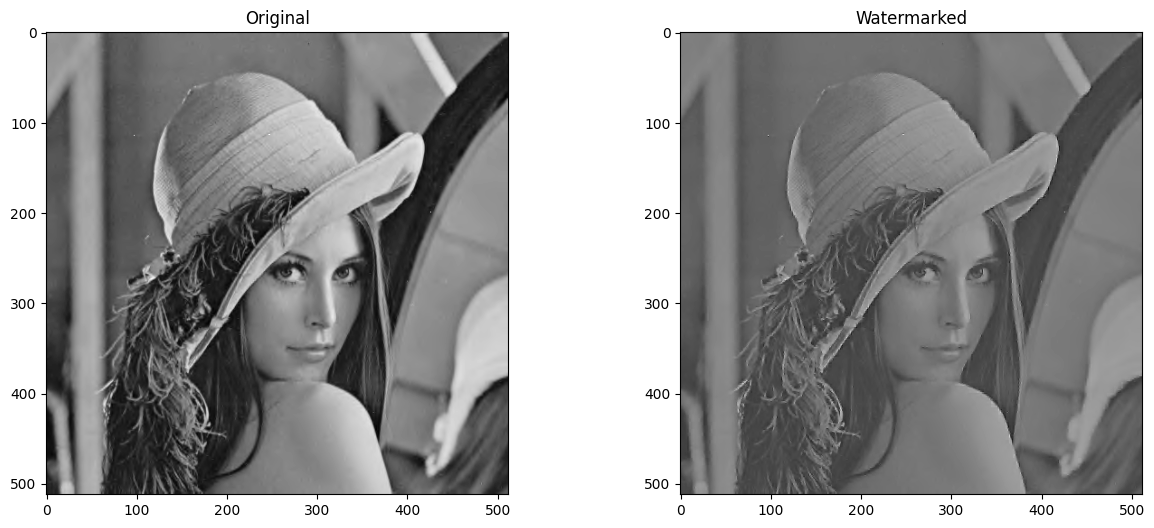

wPSNR: 42.50dB
./sample_imgs/0086.bmp
(512, 512)
0.9


Applying Resizing:  67%|██████▋   | 4/6 [00:13<00:07,  3.52s/it]  

(512, 512)
0.8987225697359849


Applying Resizing:  67%|██████▋   | 4/6 [00:14<00:07,  3.52s/it]

(512, 512)
0.57325930964509


Applying Resizing:  67%|██████▋   | 4/6 [00:15<00:07,  3.52s/it]

(512, 512)
0.8528875073065763


Applying JPEG Compression: 100%|██████████| 6/6 [00:18<00:00,  3.16s/it]


Best attack: AWGN, PSNR: 46.87567128821083, WPSNR: 58.32606852691998, Params: std: 1
{'AWGN': [{'psnr': 27.52424127335938, 'wpsnr': 39.8052044139352, 'params': 'std: 5', 'attacked_image': array([[166, 164, 165, ..., 160, 164, 135],
       [171, 159, 157, ..., 175, 156, 144],
       [159, 157, 162, ..., 162, 161, 135],
       ...,
       [ 46,  35,  44, ..., 104,  93, 102],
       [ 44,  48,  41, ..., 101, 106, 107],
       [ 45,  40,  53, ..., 106, 110,  94]], dtype=uint8)}, {'psnr': 29.032625985521815, 'wpsnr': 44.092044020358784, 'params': 'std: 9', 'attacked_image': array([[178, 157, 163, ..., 171, 176, 147],
       [167, 172, 153, ..., 180, 154, 134],
       [166, 152, 151, ..., 160, 158, 136],
       ...,
       [ 53,  45,  28, ..., 116, 104,  89],
       [ 57,  51,  69, ..., 104,  86, 111],
       [ 44,  48,  52, ...,  91, 123, 101]], dtype=uint8)}, {'psnr': 46.87567128821083, 'wpsnr': 58.32606852691998, 'params': 'std: 1', 'attacked_image': array([[160, 162, 157, ..., 169, 165, 

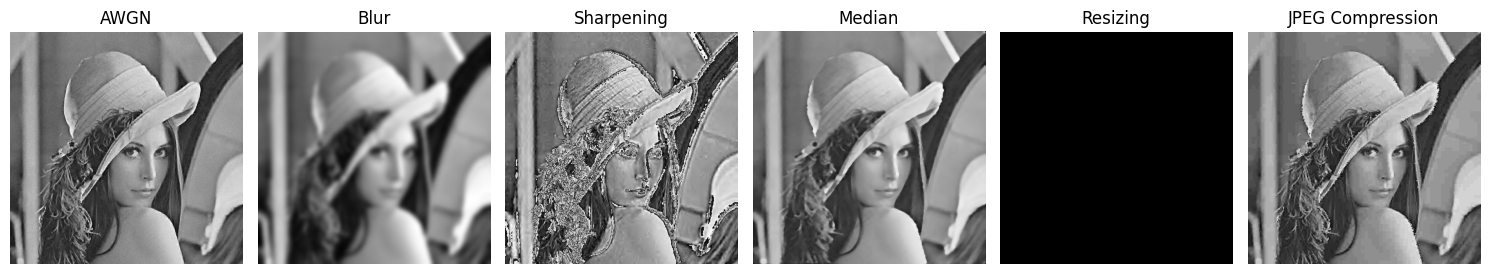

{'mean_psnr': 23.52085299746822, 'mean_wpsnr': 34.39947399639434, 'best_wpsnr': 58.32606852691998, 'worst_wpsnr': 11.634496516155817, 'total_lost': 0}


In [73]:
import os
import sys
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
sys.path.append(os.path.join(os.getcwd(), 'common'))
from utility import wpsnr
import embedding as emb
from detection import detection, similarity, compute_thr
import importlib
import attacks 
import utility
import random


# Reload the entirea module, not the function
importlib.reload(attacks)


img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.8
np.random.seed(seed=123)
mark = np.load('ammhackati.npy')






# load the image
image = cv2.imread(img_path, 0)

#Embed the watermark and save it
watermarked = emb.embedding(image, mark, alpha)

#plot the original and watermarked image
cv2.imwrite('watermarked.bmp', watermarked)
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarked,cmap='gray')
plt.show()

#check the quality of the watermarked image with respect to the original image
# psnr = cv2.PSNR(image, watermarked)
# print('PSNR: %.2fdB' % psnr)
w = wpsnr(image, watermarked)
print('wPSNR: %.2fdB' % w)


# #Detect the watermark
# w_ex = detection(image, watermarked, alpha)

# #Compute the similarity and threshold
# sim = similarity(mark, max(w_ex))
# T = 0.7#compute_thr(sim, N, mark)

# if sim > T:
#     print('Mark has been found. SIM = %f' % sim)
# else:
#     print('Mark has been lost. SIM = %f' % sim)
    


rand = random.randint(0, 100)
offset = "00" if rand < 10 else "0"
path = "./sample_imgs/0"+offset+str(rand)+".bmp"
print(path)
attacked_image = attacks.attacks(path, "Blur", [2])
attacked_image1 = attacks.attacks(path, "AWGN", [2])
attacked_image2 = attacks.attacks(path, "Blur", [2])
attacked_image3 = attacks.attacks(path, "Sharpening", [4, 3])
attacked_image4 = attacks.attacks(path, "Median", [3, 3])
attacked_image5 = attacks.attacks(path, "Resizing", [0.9])
attacked_image6 = attacks.attacks(path, "JPEG Compression", [5])
utility.visualize_images_with_desc([attacked_image,attacked_image1,attacked_image2,attacked_image3,attacked_image4,attacked_image5,attacked_image6], ['Blur','AWGN','Blur','Sharpening','Median','Resizing','JPEG Compression'])
# attacks(image_path, attack_name, param_array)
# attacked_image = attacks("path_to_image.jpg", "AWGN", [std])
# attacked_image = attacks("path_to_image.jpg", "Blur", [sigma])
# attacked_image = attacks("path_to_image.jpg", "Sharpening", [sigma, alpha])
# attacked_image = attacks("path_to_image.jpg", "Median", [kernel_size_w, kernel_size_h])
# attacked_image = attacks("path_to_image.jpg", "Resizing", [scale])
# attacked_image = attacks("path_to_image.jpg", "JPEG Compression", [QF])

(history, best) = attacks.multiple_attacks(watermarked)  
print(history) 

a_img = [entries[0]['attacked_image'] for attack_name, entries in history.items()]

a_label = history.keys()
utility.visualize_images_with_desc(a_img, a_label)
stats = attacks.stats(history)
print(stats['overall'])
attacks.plot_stats(stats)



 # Embedding and detection of lab3



WPSNR non-ATTACKED IMAGE =  62.78562248513153
WPSNR ATTACKED IMAGE =  39.7389669856196


Mark has been found in the non-attacked image. SIM = 1.000000
Mark has been lost in the attacked image. SIM = 0.667014
--------------------------




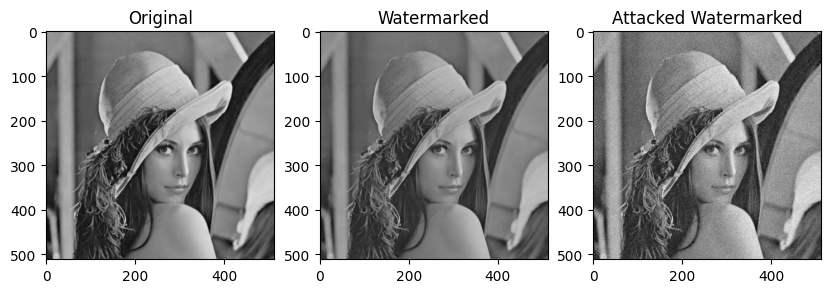

In [112]:
#5
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    #print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def embedding(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Get the locations in LH
    sign_LH = np.sign(LH)
    abs_LH = abs(LH)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL)
    abs_HL = abs(HL)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH)
    abs_HH = abs(HH)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates
    # Embed the watermark in LH
    watermarked_LH = abs_LH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH[1:], mark)):
        if v == 'additive':
            watermarked_LH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HL = abs_HL.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL[1:], mark)):
        if v == 'additive':
            watermarked_HL[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HH = abs_HH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH[1:], mark)):
        if v == 'additive':
            watermarked_HH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH
    watermarked = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')

    return mark, watermarked

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2

    #
    # Get the locations in LH
    sign_LH = np.sign(LH_or)
    abs_LH = abs(LH_or)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH_or.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL_or)
    abs_HL = abs(HL_or)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL_or.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH_or)
    abs_HH = abs(HH_or)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH_or.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) / (alpha*LH_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) / (alpha*HL_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) / (alpha*HH_or[loc])
    
    w_ex = (w_ex1 + w_ex2 + w_ex3)/3
    return w_ex


plt.figure(figsize=(10, 10))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.5
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)
#your attack
attacked = awgn(watermarked1, 15, 123)
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity(w_ex,w_ex_att)
sim_NOTattacked = similarity(mark,w_ex)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')


Applying AWGN:   0%|          | 0/8 [00:02<?, ?it/s]   

40.61471169148328


Applying AWGN:   0%|          | 0/8 [00:04<?, ?it/s]

34.82514830816887


Applying AWGN:   0%|          | 0/8 [00:07<?, ?it/s]

26.765290798214924


Applying AWGN:   0%|          | 0/8 [00:09<?, ?it/s]

26.36157269576533


Applying AWGN:   0%|          | 0/8 [00:11<?, ?it/s]

26.861732447465595


Applying AWGN:   0%|          | 0/8 [00:13<?, ?it/s]

25.581505003008658


Applying AWGN:   0%|          | 0/8 [00:15<?, ?it/s]

33.161559858510934


Applying AWGN:   0%|          | 0/8 [00:17<?, ?it/s]

26.43763557144667


Applying AWGN:   0%|          | 0/8 [00:20<?, ?it/s]

28.410348886551944


Applying AWGN:   0%|          | 0/8 [00:22<?, ?it/s]

37.663337884821225


Applying AWGN:   0%|          | 0/8 [00:24<?, ?it/s]

30.496948409400417


Applying AWGN:   0%|          | 0/8 [00:26<?, ?it/s]

31.826428122813848


Applying AWGN:   0%|          | 0/8 [00:28<?, ?it/s]

32.47234906342177


Applying AWGN:   0%|          | 0/8 [00:30<?, ?it/s]

40.59619360087544


Applying AWGN:   0%|          | 0/8 [00:33<?, ?it/s]

25.74918373407516


Applying AWGN:   0%|          | 0/8 [00:35<?, ?it/s]

29.7156338438894


Applying AWGN:   0%|          | 0/8 [00:37<?, ?it/s]

25.418888091321232


Applying AWGN:   0%|          | 0/8 [00:39<?, ?it/s]

26.77065947288242


Applying AWGN:   0%|          | 0/8 [00:42<?, ?it/s]

35.801796594665845


Applying Blur:  12%|█▎        | 1/8 [00:44<05:09, 44.20s/it]

32.49473442067577


Applying Blur:  12%|█▎        | 1/8 [00:46<05:09, 44.20s/it]

23.481379668170238


Applying Blur:  12%|█▎        | 1/8 [00:48<05:09, 44.20s/it]

30.937622015866417


Applying Blur:  12%|█▎        | 1/8 [00:50<05:09, 44.20s/it]

24.014071608786658


Applying Blur:  12%|█▎        | 1/8 [00:52<05:09, 44.20s/it]

36.60027566922952


Applying Blur:  12%|█▎        | 1/8 [00:55<05:09, 44.20s/it]

24.908244916810748


Applying Blur:  12%|█▎        | 1/8 [00:57<05:09, 44.20s/it]

22.29580391219624


Applying Blur:  12%|█▎        | 1/8 [00:59<05:09, 44.20s/it]

22.658035975733412


Applying Blur:  12%|█▎        | 1/8 [01:01<05:09, 44.20s/it]

25.371440595960454


Applying Blur:  12%|█▎        | 1/8 [01:03<05:09, 44.20s/it]

24.703077960991973


Applying Blur:  12%|█▎        | 1/8 [01:06<05:09, 44.20s/it]

22.972515066916735


Applying Blur:  12%|█▎        | 1/8 [01:08<05:09, 44.20s/it]

25.634703684175676


Applying Blur:  12%|█▎        | 1/8 [01:11<05:09, 44.20s/it]

22.524420900298313


Applying Blur:  12%|█▎        | 1/8 [01:14<05:09, 44.20s/it]

23.481379668170238


Applying Blur:  12%|█▎        | 1/8 [01:16<05:09, 44.20s/it]

25.371440595960454


Applying Blur:  12%|█▎        | 1/8 [01:18<05:09, 44.20s/it]

22.658035975733412


Applying Blur:  12%|█▎        | 1/8 [01:21<05:09, 44.20s/it]

25.634703684175676


Applying Blur:  12%|█▎        | 1/8 [01:23<05:09, 44.20s/it]

22.524420900298313


Applying Blur:  12%|█▎        | 1/8 [01:26<05:09, 44.20s/it]

25.371440595960454


Applying Blur:  12%|█▎        | 1/8 [01:28<05:09, 44.20s/it]

23.731282577503112


Applying Sharpening:  25%|██▌       | 2/8 [01:30<04:33, 45.52s/it]

24.512519923433295


Applying Sharpening:  25%|██▌       | 2/8 [01:33<04:33, 45.52s/it]

17.829377090151503


Applying Sharpening:  25%|██▌       | 2/8 [01:35<04:33, 45.52s/it]

16.007593571122875


Applying Sharpening:  25%|██▌       | 2/8 [01:37<04:33, 45.52s/it]

17.895146480196573


Applying Sharpening:  25%|██▌       | 2/8 [01:40<04:33, 45.52s/it]

17.746298695967738


Applying Sharpening:  25%|██▌       | 2/8 [01:42<04:33, 45.52s/it]

18.153243061406254


Applying Sharpening:  25%|██▌       | 2/8 [01:44<04:33, 45.52s/it]

17.436994140404124


Applying Sharpening:  25%|██▌       | 2/8 [01:46<04:33, 45.52s/it]

18.28938715211479


Applying Sharpening:  25%|██▌       | 2/8 [01:49<04:33, 45.52s/it]

17.266878632227932


Applying Sharpening:  25%|██▌       | 2/8 [01:51<04:33, 45.52s/it]

17.83583945991578


Applying Sharpening:  25%|██▌       | 2/8 [01:53<04:33, 45.52s/it]

18.24083131692642


Applying Sharpening:  25%|██▌       | 2/8 [01:56<04:33, 45.52s/it]

18.044783398762693


Applying Sharpening:  25%|██▌       | 2/8 [01:58<04:33, 45.52s/it]

15.925402920294216


Applying Sharpening:  25%|██▌       | 2/8 [02:00<04:33, 45.52s/it]

18.0380692310305


Applying Sharpening:  25%|██▌       | 2/8 [02:03<04:33, 45.52s/it]

16.777926651840737


Applying Sharpening:  25%|██▌       | 2/8 [02:05<04:33, 45.52s/it]

17.541239248355346


Applying Sharpening:  25%|██▌       | 2/8 [02:08<04:33, 45.52s/it]

16.809247780399097


Applying Sharpening:  25%|██▌       | 2/8 [02:10<04:33, 45.52s/it]

18.024395085575854


Applying Sharpening:  25%|██▌       | 2/8 [02:12<04:33, 45.52s/it]

18.034988664918743


Applying Sharpening:  25%|██▌       | 2/8 [02:14<04:33, 45.52s/it]

17.677016036424057


Applying Median:  38%|███▊      | 3/8 [02:19<03:49, 45.90s/it]    

17.747863625568336


Applying Median:  38%|███▊      | 3/8 [02:21<03:49, 45.90s/it]

33.40130722486898


Applying Median:  38%|███▊      | 3/8 [02:24<03:49, 45.90s/it]

41.57207736532381


Applying Median:  38%|███▊      | 3/8 [02:26<03:49, 45.90s/it]

47.192302660097425


Applying Median:  38%|███▊      | 3/8 [02:31<03:49, 45.90s/it]

41.59579569238737


Applying Median:  38%|███▊      | 3/8 [02:33<03:49, 45.90s/it]

33.40130722486898


Applying Median:  38%|███▊      | 3/8 [02:37<03:49, 45.90s/it]

38.92492508805303


Applying Median:  38%|███▊      | 3/8 [02:40<03:49, 45.90s/it]

33.771185361601184


Applying Median:  38%|███▊      | 3/8 [02:44<03:49, 45.90s/it]

36.5202891334873


Applying Median:  38%|███▊      | 3/8 [02:47<03:49, 45.90s/it]

34.127159136768


Applying Median:  38%|███▊      | 3/8 [02:50<03:49, 45.90s/it]

36.329492577272596


Applying Median:  38%|███▊      | 3/8 [02:53<03:49, 45.90s/it]

37.335204976284345


Applying Median:  38%|███▊      | 3/8 [02:56<03:49, 45.90s/it]

44.96901497350745


Applying Median:  38%|███▊      | 3/8 [02:59<03:49, 45.90s/it]

37.335204976284345


Applying Median:  38%|███▊      | 3/8 [03:02<03:49, 45.90s/it]

36.04252203650965


Applying Median:  38%|███▊      | 3/8 [03:04<03:49, 45.90s/it]

37.83296268417517


Applying Median:  38%|███▊      | 3/8 [03:08<03:49, 45.90s/it]

38.92492508805303


Applying Median:  38%|███▊      | 3/8 [03:11<03:49, 45.90s/it]

34.95255155205076


Applying Median:  38%|███▊      | 3/8 [03:13<03:49, 45.90s/it]

39.585881378396515


Applying Median:  38%|███▊      | 3/8 [03:17<03:49, 45.90s/it]

41.59579569238737


Applying Resizing:  50%|█████     | 4/8 [03:19<03:30, 52.55s/it]

34.95255155205076


Applying Resizing:  50%|█████     | 4/8 [03:22<03:30, 52.55s/it]

48.22152540537414


Applying Resizing:  50%|█████     | 4/8 [03:24<03:30, 52.55s/it]

42.75030878128447


Applying Resizing:  50%|█████     | 4/8 [03:26<03:30, 52.55s/it]

46.670784194813635


Applying Resizing:  50%|█████     | 4/8 [03:29<03:30, 52.55s/it]

49.18447733624653


Applying Resizing:  50%|█████     | 4/8 [03:31<03:30, 52.55s/it]

48.38208447768922


Applying Resizing:  50%|█████     | 4/8 [03:34<03:30, 52.55s/it]

39.5353201538382


Applying Resizing:  50%|█████     | 4/8 [03:36<03:30, 52.55s/it]

47.086021892074655


Applying Resizing:  50%|█████     | 4/8 [03:39<03:30, 52.55s/it]

40.21018270173602


Applying Resizing:  50%|█████     | 4/8 [03:41<03:30, 52.55s/it]

47.96795320849918


Applying Resizing:  50%|█████     | 4/8 [03:44<03:30, 52.55s/it]

45.95150944928016


Applying Resizing:  50%|█████     | 4/8 [03:46<03:30, 52.55s/it]

41.077723577829275


Applying Resizing:  50%|█████     | 4/8 [03:48<03:30, 52.55s/it]

39.0906884205507


Applying Resizing:  50%|█████     | 4/8 [03:51<03:30, 52.55s/it]

48.80884379573725


Applying Resizing:  50%|█████     | 4/8 [03:53<03:30, 52.55s/it]

49.26955670150208


Applying Resizing:  50%|█████     | 4/8 [03:56<03:30, 52.55s/it]

48.56180491537817


Applying Resizing:  50%|█████     | 4/8 [03:58<03:30, 52.55s/it]

46.89882244691594


Applying Resizing:  50%|█████     | 4/8 [04:00<03:30, 52.55s/it]

48.12134139712889


Applying Resizing:  50%|█████     | 4/8 [04:03<03:30, 52.55s/it]

49.13072912491083


Applying Resizing:  50%|█████     | 4/8 [04:05<03:30, 52.55s/it]

39.162973174511656


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:08<02:33, 51.13s/it]

48.78019448647008


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:10<02:33, 51.13s/it]

37.41340798539477


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:12<02:33, 51.13s/it]

42.48601726892705


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:14<02:33, 51.13s/it]

34.05018525834664


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:17<02:33, 51.13s/it]

31.227998373263574


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:19<02:33, 51.13s/it]

45.14544610651525


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:21<02:33, 51.13s/it]

46.063703148586164


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:23<02:33, 51.13s/it]

45.85582516235731


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:25<02:33, 51.13s/it]

47.05461815557673


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:27<02:33, 51.13s/it]

44.652237069267045


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:30<02:33, 51.13s/it]

45.60372753278243


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:32<02:33, 51.13s/it]

45.962389200673144


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:34<02:33, 51.13s/it]

46.71228619082994


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:36<02:33, 51.13s/it]

39.64607871153939


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:38<02:33, 51.13s/it]

45.22169741993298


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:40<02:33, 51.13s/it]

46.79342442886479


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:43<02:33, 51.13s/it]

42.92203702563569


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:45<02:33, 51.13s/it]

40.15986863752785


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:47<02:33, 51.13s/it]

47.076367009044034


Applying JPEG Compression:  62%|██████▎   | 5/8 [04:49<02:33, 51.13s/it]

46.2390153042935


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [04:51<01:37, 48.51s/it]       

31.234211364297643


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [04:53<01:37, 48.51s/it]

48.14931097273886


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [04:56<01:37, 48.51s/it]

48.1422934755155


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [04:58<01:37, 48.51s/it]

48.1422934755155


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:00<01:37, 48.51s/it]

48.141603614433315


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:02<01:37, 48.51s/it]

48.100203195389746


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:04<01:37, 48.51s/it]

48.12650208694056


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:07<01:37, 48.51s/it]

48.1447549618059


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:10<01:37, 48.51s/it]

48.1447549618059


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:12<01:37, 48.51s/it]

48.14933144811832


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:15<01:37, 48.51s/it]

48.14486242162402


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:18<01:37, 48.51s/it]

48.148048177779366


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:20<01:37, 48.51s/it]

48.14931097273886


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:23<01:37, 48.51s/it]

48.148048177779366


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:25<01:37, 48.51s/it]

48.14486242162402


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:28<01:37, 48.51s/it]

48.14931097273886


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:30<01:37, 48.51s/it]

48.031058711157954


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:32<01:37, 48.51s/it]

48.12650208694056


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:35<01:37, 48.51s/it]

48.111235717125034


Applying DWT_GAUSS:  75%|███████▌  | 6/8 [05:37<01:37, 48.51s/it]

48.148048177779366


Applying DWT_GAUSS:  88%|████████▊ | 7/8 [05:39<00:48, 48.40s/it]

48.031058711157954


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [05:40<00:48, 48.40s/it]

48.11469867456297


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [05:43<00:48, 48.40s/it]

48.18004394633136


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [05:46<00:48, 48.40s/it]

48.13587194193177


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [05:48<00:48, 48.40s/it]

48.1778196098532


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [05:51<00:48, 48.40s/it]

48.066732557911244


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [05:54<00:48, 48.40s/it]

48.089243509475224


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [05:57<00:48, 48.40s/it]

48.18984096219847


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:01<00:48, 48.40s/it]

48.1822176043448


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:03<00:48, 48.40s/it]

48.09740152739206


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:06<00:48, 48.40s/it]

48.17977606893465


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:09<00:48, 48.40s/it]

48.16891190924308


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:12<00:48, 48.40s/it]

48.17977606893465


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:15<00:48, 48.40s/it]

48.196359018579685


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:19<00:48, 48.40s/it]

48.20846784563754


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:22<00:48, 48.40s/it]

48.203434117094126


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:25<00:48, 48.40s/it]

48.1778196098532


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:29<00:48, 48.40s/it]

48.20691409021886


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:31<00:48, 48.40s/it]

48.02987791136226


Applying DWT_MEIDAN:  88%|████████▊ | 7/8 [06:33<00:48, 48.40s/it]

48.02987791136226


Applying DWT_MEIDAN: 100%|██████████| 8/8 [06:39<00:00, 49.93s/it]

48.2113132892189
Ratio mark found/total attack in attacked image: 43 / 160
Ratio mark found/total attack in non-attacked image: 0 / 160
Average WPSNR in attacked image: 37.00675395577774
Average WPSNR in non-attacked image: 47.14228421490249
Average WPSNR for non detected watermark in attacked image: 32.99773626626653


Attack Name: AWGN
Average mark found for: 1
Best WPSNR non detected watermark: 40.59619360087544
Best Parameters non detected watermark: std: 12
Average WPSNR for non detected watermark (19): 30.390049831998706
Used Parameters for detected watermark: [('std: 12', 40.61471169148328, True)]
Used Parameters for non detected watermark: [('std: 26', 34.82514830816887, False), ('std: 74', 26.765290798214924, False), ('std: 78', 26.36157269576533, False), ('std: 73', 26.861732447465595, False), ('std: 88', 25.581505003008658, False), ('std: 32', 33.161559858510934, False), ('std: 77', 26.43763557144667, False), ('std: 59', 28.410348886551944, False), ('std: 18', 37.66333788482

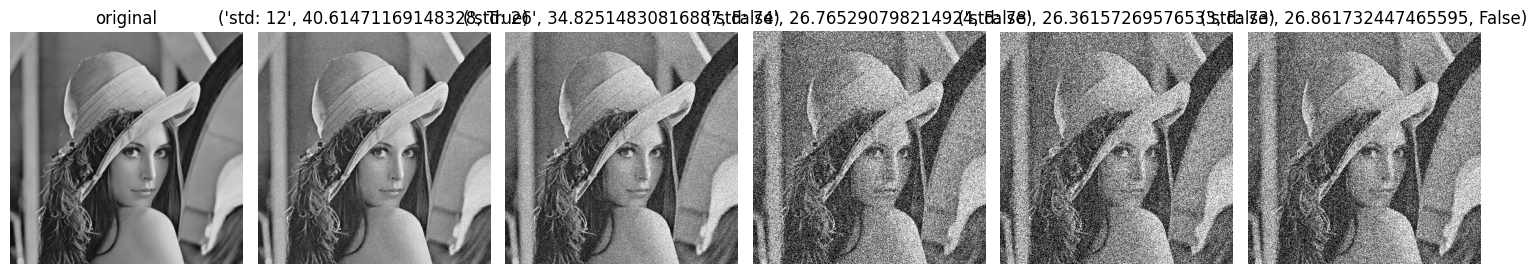



Attack Name: Blur
Average mark found for: 0
Best WPSNR non detected watermark: 36.60027566922952
Best Parameters non detected watermark: sigma: 2
Average WPSNR for non detected watermark (20): 24.969340794818567
Used Parameters for detected watermark: []
Used Parameters for non detected watermark: [('sigma: 25', 23.481379668170238, False), ('sigma: 4', 30.937622015866417, False), ('sigma: 21', 24.014071608786658, False), ('sigma: 2', 36.60027566922952, False), ('sigma: 16', 24.908244916810748, False), ('sigma: 40', 22.29580391219624, False), ('sigma: 34', 22.658035975733412, False), ('sigma: 14', 25.371440595960454, False), ('sigma: 17', 24.703077960991973, False), ('sigma: 30', 22.972515066916735, False), ('sigma: 13', 25.634703684175676, False), ('sigma: 36', 22.524420900298313, False), ('sigma: 25', 23.481379668170238, False), ('sigma: 14', 25.371440595960454, False), ('sigma: 34', 22.658035975733412, False), ('sigma: 13', 25.634703684175676, False), ('sigma: 36', 22.5244209002983

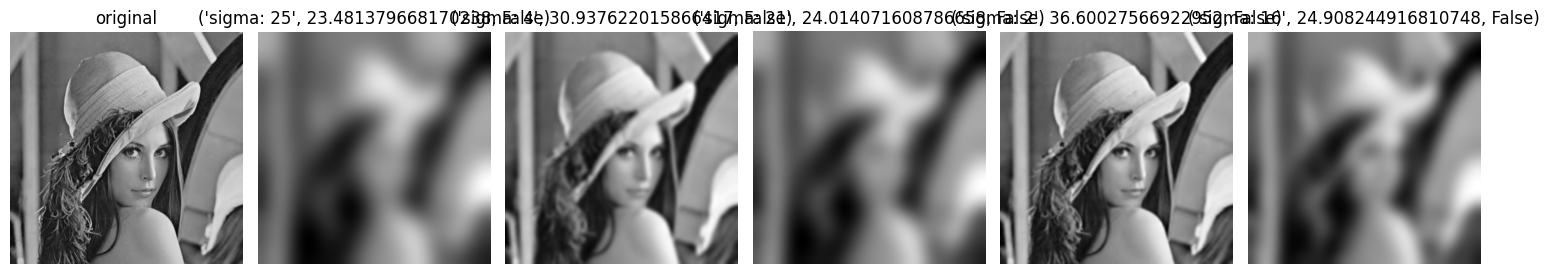



Attack Name: Sharpening
Average mark found for: 0
Best WPSNR non detected watermark: 18.28938715211479
Best Parameters non detected watermark: sigma: 6 alpha: 18
Average WPSNR for non detected watermark (20): 17.56612611218018
Used Parameters for detected watermark: []
Used Parameters for non detected watermark: [('sigma: 27 alpha: 26', 17.829377090151503, False), ('sigma: 22 alpha: 2', 16.007593571122875, False), ('sigma: 7 alpha: 11', 17.895146480196573, False), ('sigma: 29 alpha: 24', 17.746298695967738, False), ('sigma: 10 alpha: 28', 18.153243061406254, False), ('sigma: 13 alpha: 14', 17.436994140404124, False), ('sigma: 6 alpha: 18', 18.28938715211479, False), ('sigma: 19 alpha: 14', 17.266878632227932, False), ('sigma: 23 alpha: 24', 17.83583945991578, False), ('sigma: 9 alpha: 30', 18.24083131692642, False), ('sigma: 24 alpha: 29', 18.044783398762693, False), ('sigma: 27 alpha: 3', 15.925402920294216, False), ('sigma: 23 alpha: 29', 18.0380692310305, False), ('sigma: 17 alpha

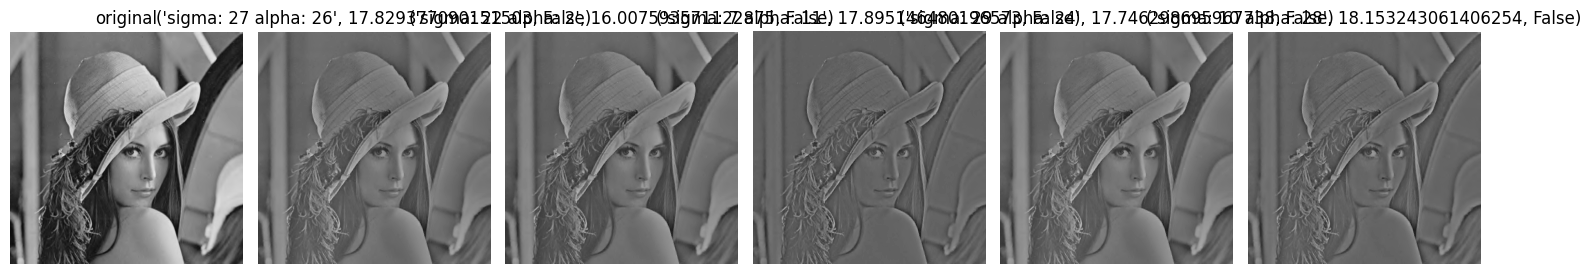



Attack Name: Median
Average mark found for: 0
Best WPSNR non detected watermark: 47.192302660097425
Best Parameters non detected watermark: kernel_size: [3, 3]
Average WPSNR for non detected watermark (20): 38.0181228187214
Used Parameters for detected watermark: []
Used Parameters for non detected watermark: [('kernel_size: [11, 11]', 33.40130722486898, False), ('kernel_size: [5, 5]', 41.57207736532381, False), ('kernel_size: [3, 3]', 47.192302660097425, False), ('kernel_size: [7, 3]', 41.59579569238737, False), ('kernel_size: [11, 11]', 33.40130722486898, False), ('kernel_size: [3, 7]', 38.92492508805303, False), ('kernel_size: [9, 11]', 33.771185361601184, False), ('kernel_size: [11, 5]', 36.5202891334873, False), ('kernel_size: [7, 11]', 34.127159136768, False), ('kernel_size: [9, 7]', 36.329492577272596, False), ('kernel_size: [7, 7]', 37.335204976284345, False), ('kernel_size: [5, 3]', 44.96901497350745, False), ('kernel_size: [7, 7]', 37.335204976284345, False), ('kernel_size:

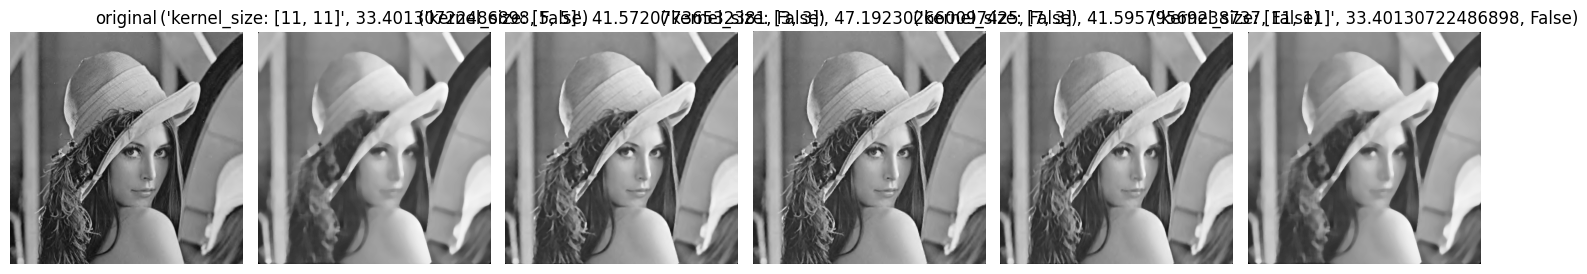



Attack Name: Resizing
Average mark found for: 0
Best WPSNR non detected watermark: 49.26955670150208
Best Parameters non detected watermark: scale: 0.9519057040848753
Average WPSNR for non detected watermark (20): 45.74314228208855
Used Parameters for detected watermark: []
Used Parameters for non detected watermark: [('scale: 0.7044859052413569', 48.22152540537414, False), ('scale: 0.4582488348258571', 42.75030878128447, False), ('scale: 0.6256328195556136', 46.670784194813635, False), ('scale: 0.9005461874669796', 49.18447733624653, False), ('scale: 0.7563003996183446', 48.38208447768922, False), ('scale: 0.3656962746483129', 39.5353201538382, False), ('scale: 0.6533328673851044', 47.086021892074655, False), ('scale: 0.3835468837622197', 40.21018270173602, False), ('scale: 0.684889737937949', 47.96795320849918, False), ('scale: 0.5793561492553758', 45.95150944928016, False), ('scale: 0.4053482891373376', 41.077723577829275, False), ('scale: 0.3542747305080591', 39.0906884205507, Fa

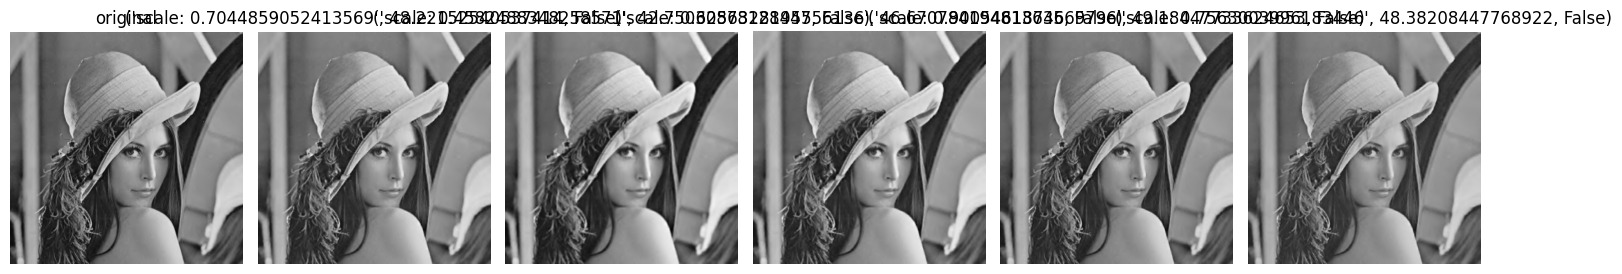



Attack Name: JPEG Compression
Average mark found for: 2
Best WPSNR non detected watermark: 46.79342442886479
Best Parameters non detected watermark: QF: 77
Average WPSNR for non detected watermark (18): 42.07719756605751
Used Parameters for detected watermark: [('QF: 93', 47.05461815557673, True), ('QF: 99', 47.076367009044034, True)]
Used Parameters for non detected watermark: [('QF: 7', 37.41340798539477, False), ('QF: 17', 42.48601726892705, False), ('QF: 4', 34.05018525834664, False), ('QF: 1', 31.227998373263574, False), ('QF: 35', 45.14544610651525, False), ('QF: 53', 46.063703148586164, False), ('QF: 47', 45.85582516235731, False), ('QF: 30', 44.652237069267045, False), ('QF: 42', 45.60372753278243, False), ('QF: 49', 45.962389200673144, False), ('QF: 75', 46.71228619082994, False), ('QF: 10', 39.64607871153939, False), ('QF: 37', 45.22169741993298, False), ('QF: 77', 46.79342442886479, False), ('QF: 19', 42.92203702563569, False), ('QF: 11', 40.15986863752785, False), ('QF: 5



Attack Name: DWT_GAUSS
Average mark found for: 20
Best WPSNR non detected watermark: 0
Best Parameters non detected watermark: 
Average WPSNR for non detected watermark: 0
Used Parameters for detected watermark: [('sigma: 13', 48.14931097273886, True), ('sigma: 6', 48.1422934755155, True), ('sigma: 6', 48.1422934755155, True), ('sigma: 9', 48.141603614433315, True), ('sigma: 3', 48.100203195389746, True), ('sigma: 4', 48.12650208694056, True), ('sigma: 8', 48.1447549618059, True), ('sigma: 8', 48.1447549618059, True), ('sigma: 17', 48.14933144811832, True), ('sigma: 10', 48.14486242162402, True), ('sigma: 19', 48.148048177779366, True), ('sigma: 13', 48.14931097273886, True), ('sigma: 19', 48.148048177779366, True), ('sigma: 10', 48.14486242162402, True), ('sigma: 13', 48.14931097273886, True), ('sigma: 2', 48.031058711157954, True), ('sigma: 4', 48.12650208694056, True), ('sigma: 1', 48.111235717125034, True), ('sigma: 19', 48.148048177779366, True), ('sigma: 2', 48.031058711157954,

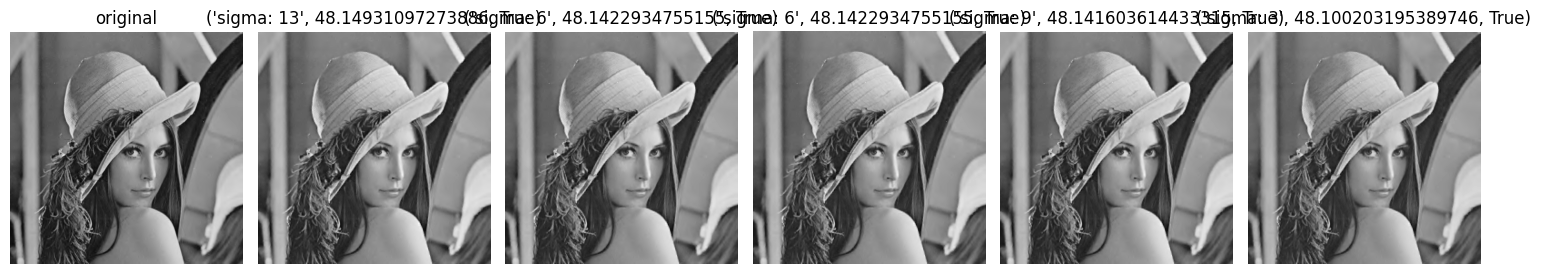



Attack Name: DWT_MEIDAN
Average mark found for: 20
Best WPSNR non detected watermark: 0
Best Parameters non detected watermark: 
Average WPSNR for non detected watermark: 0
Used Parameters for detected watermark: [('kernel_size: [3, 7]', 48.11469867456297, True), ('kernel_size: [5, 9]', 48.18004394633136, True), ('kernel_size: [5, 7]', 48.13587194193177, True), ('kernel_size: [3, 9]', 48.1778196098532, True), ('kernel_size: [9, 5]', 48.066732557911244, True), ('kernel_size: [11, 5]', 48.089243509475224, True), ('kernel_size: [5, 11]', 48.18984096219847, True), ('kernel_size: [9, 7]', 48.1822176043448, True), ('kernel_size: [9, 3]', 48.09740152739206, True), ('kernel_size: [3, 11]', 48.17977606893465, True), ('kernel_size: [7, 7]', 48.16891190924308, True), ('kernel_size: [3, 11]', 48.17977606893465, True), ('kernel_size: [7, 9]', 48.196359018579685, True), ('kernel_size: [11, 11]', 48.20846784563754, True), ('kernel_size: [7, 11]', 48.203434117094126, True), ('kernel_size: [3, 9]', 4

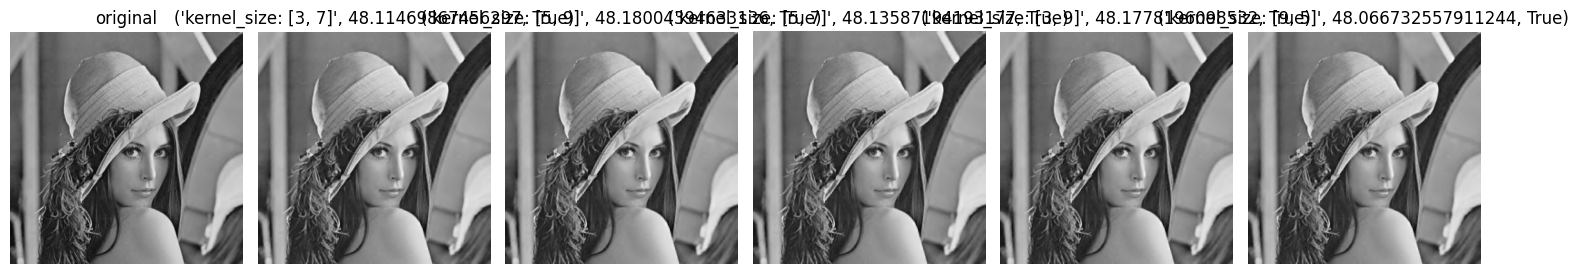

In [182]:
import attacks
from tqdm import tqdm
import importlib
importlib.reload(attacks)
import embedding
importlib.reload(attacks)

import detection
importlib.reload(detection)


img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24
v = 'multiplicative'
alpha = 0.5
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)
#image, mark, alpha, max_layer=2, v='multiplicative'
watermarked1 = embedding.embedding(image,mark,  alpha)

total_attacks = 0
total_attacks_mark_found = 0
non_attacked_mark_found = 0
total_wpsnr_non_attacked = 0
total_wpsnr_attacked = 0
total_wpsnr_non_detected = 0 #average wpsnr non detected watermark for attacked images

attack_functions= attacks.random_attack_list()
# print(attack_functions)
progress_bar = tqdm(attack_functions, desc="Applying attacks")


average_attack = {

}

for _, attack_fn in enumerate(progress_bar):
    attack_type_times = 0
    local_wpsnr = 0
    attack_mark_found = 0
    best_wpsnr = 0
    best_params = ""
    average_non_detected_wpsnr = 0
    local_used_params = []  
    #local_used_params_detected = []  
    local_attacked_image = []
    for _ in range(20):
        attack_type_times += 1
        (attacked,attack_name,used_params) = attack_fn(watermarked1)
        local_attacked_image.append(attacked)
        progress_bar.set_description(f"Applying {attack_name}")
        attacked = attacked.astype(np.uint8)
        image = image.astype(np.uint8)

        #detection original, watermarked, attacked, alpha, max_layer
        w_ex = detection.detection(image, watermarked1,attacked, alpha, 2)

        #wpsnr
        wspnr_watermarked = wpsnr(image, watermarked1)
        wpsnr_attacked = wpsnr(image, attacked)
        print(wpsnr_attacked)

        local_wpsnr += wpsnr_attacked
        total_wpsnr_non_attacked += wspnr_watermarked
        # #similarity
        # sim_attacked = similarity(w_ex,w_ex_att)
        # sim_not_attacked = similarity(mark,w_ex)
        # Tau, _ = compute_thr(sim_not_attacked, N, mark, 1000)
        #watermark retrieved?
        #erate status message
        status = "\n"
        status += f"WPSNR non-ATTACKED IMAGE = {wspnr_watermarked}\n"
        status += f"WPSNR ATTACKED IMAGE = {wpsnr_attacked}\n"

        # if w_ex == 1:
        #     non_attacked_mark_found += 1
        #     status += f"Mark found in non-attacked image. SIM = {sim_not_attacked:.6f}\n"
        # else:
        #     status += f"Mark lost in non-attacked image. SIM = {sim_not_attacked:.6f}\n"

        if w_ex ==1:
            attack_mark_found += 1
            local_used_params.append((used_params,wpsnr_attacked,True))
            # status += f"Mark found in attacked image. SIM = {sim_attacked:.6f}\n"
        else:
            # status += f"Mark lost in attacked image. SIM = {sim_attacked:.6f}\n"
            local_used_params.append((used_params,wpsnr_attacked,False))
            if wpsnr_attacked > best_wpsnr:
                best_wpsnr = wpsnr_attacked
                best_params = used_params
            average_non_detected_wpsnr += wpsnr_attacked

        status += "--------------------------\n"
        # Print status message
        #progress_bar.write(status)

    average_attack[attack_name] ={
        'attack_type_times':attack_type_times,
        'local_wpsnr':local_wpsnr,
        'attack_mark_found':attack_mark_found,
        'best_params':best_params,
        'best_wpsnr':best_wpsnr,
        'average_non_detected_wpsnr':average_non_detected_wpsnr,
        'local_used_params':local_used_params,
        'attacked_image':local_attacked_image
    }

    total_attacks_mark_found += attack_mark_found
    total_attacks += attack_type_times
    total_wpsnr_attacked += local_wpsnr
    total_wpsnr_non_detected += average_non_detected_wpsnr


print(f"Ratio mark found/total attack in attacked image: {total_attacks_mark_found} / {total_attacks}")
print(f"Ratio mark found/total attack in non-attacked image: {non_attacked_mark_found} / {total_attacks}")
print(f"Average WPSNR in attacked image: {total_wpsnr_attacked /total_attacks}")
print(f"Average WPSNR in non-attacked image: {total_wpsnr_non_attacked/ total_attacks}")
if (total_attacks-total_attacks_mark_found) == 0:
    print(f"Average WPSNR for non detected watermark in attacked image: {total_wpsnr_non_detected}")
else:
    print(f"Average WPSNR for non detected watermark in attacked image: {total_wpsnr_non_detected/(total_attacks-total_attacks_mark_found)}")
for attack_name, values in average_attack.items():
    print("\n")
    print("Attack Name: "+attack_name)
    print(f"Average mark found for: {values['attack_mark_found']}")
    print(f"Best WPSNR non detected watermark: {values['best_wpsnr']}")
    print(f"Best Parameters non detected watermark: {values['best_params']}")
    non_detected_mark = values['attack_type_times']-values['attack_mark_found']
    if non_detected_mark == 0:
        print(f"Average WPSNR for non detected watermark: {values['average_non_detected_wpsnr']}")#should be 0
    else:
        print(f"Average WPSNR for non detected watermark ({non_detected_mark}): {values['average_non_detected_wpsnr']/non_detected_mark}")  

    print(f"Used Parameters for detected watermark: {list(filter(lambda x:x[2],values['local_used_params']))}")
    print(f"Used Parameters for non detected watermark: {list(filter(lambda x: not x[2],values['local_used_params']))}")
    utility.visualize_images_with_desc([image]+values['attacked_image'][:5], ["original"] + values['local_used_params'][:5])
    



# import utility
# importlib.reload(attacks)
# prova = attacks.apply_gaussian_blur_to_dwt(watermarked1, 2)
# utility.visualize_images_with_desc([watermarked1, prova], ['Watermarked', 'attacked'])

import csv
csv_file = 'attack_results.csv'

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow([
        "Attack Name", 
        "WPSNR Attacked", 
        "Mark Found", 
        "Parameters"
    ])
    
    # Write each attack result, including every parameter used in the attacks
    for attack_name, values in average_attack.items():
        for params in values['local_used_params']:
            used_params, wpsnr_attacked, mark_found = params
            writer.writerow([
                attack_name, 
                wpsnr_attacked, 
                mark_found, 
                used_params
            ])




In [161]:
# import utility
# importlib.reload(attacks)
# prova = attacks.apply_gaussian_blur_to_dwt(watermarked1, 2)
# utility.visualize_images_with_desc([watermarked1, prova], ['Watermarked', 'attacked'])

import csv
csv_file = 'attack_results.csv'

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow([
        "Attack Name", 
        "WPSNR Attacked", 
        "Mark Found", 
        "Parameters"
    ])
    
    # Write each attack result, including every parameter used in the attacks
    for attack_name, values in average_attack.items():
        for params in values['local_used_params']:
            used_params, wpsnr_attacked, mark_found = params
            writer.writerow([
                attack_name, 
                wpsnr_attacked, 
                mark_found, 
                used_params
            ])


Mean WPSNR Attacked (Not Detected): 38.93460114054372


/tmp/ipykernel_26146/427194017.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Attack Name', y='WPSNR Attacked', data=not_detected_df, palette='viridis')


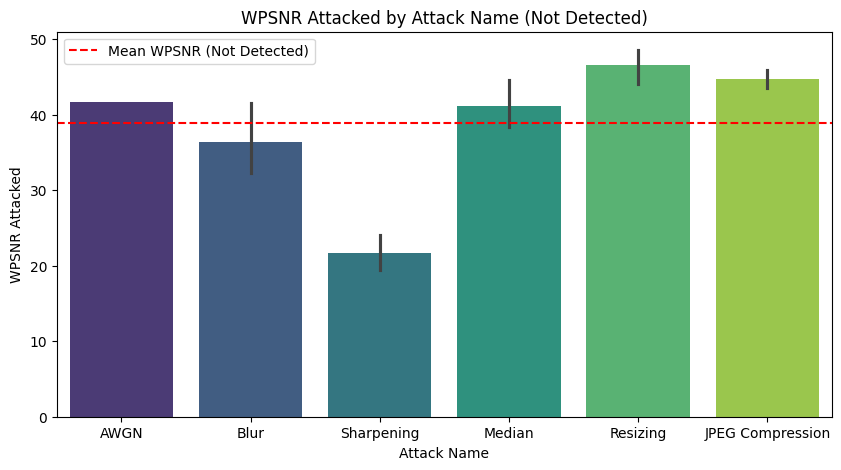

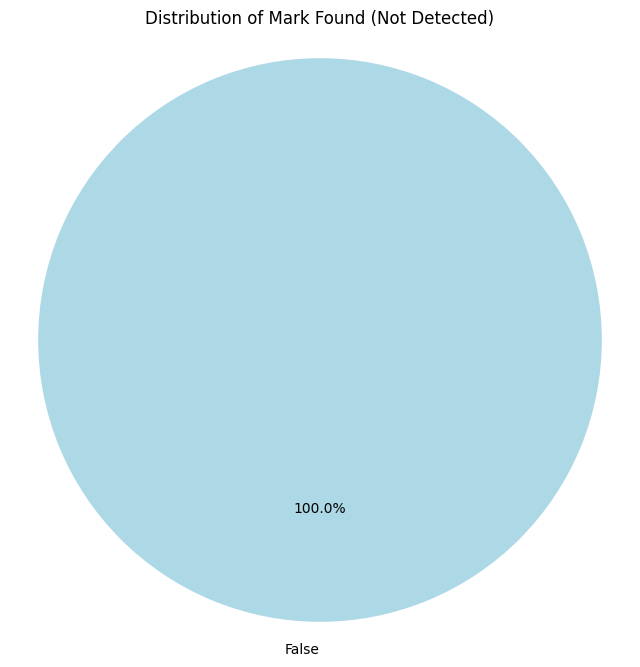

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data from file.csv
df = pd.read_csv('./attack_results.csv')

# Convert WPSNR Attacked to numeric
df['WPSNR Attacked'] = pd.to_numeric(df['WPSNR Attacked'])

# Filter for rows where the mark is not found
not_detected_df = df[df['Mark Found'] == False]

# Calculate mean WPSNR for the filtered data
mean_wpsnr_not_detected = not_detected_df['WPSNR Attacked'].mean()
print(f"Mean WPSNR Attacked (Not Detected): {mean_wpsnr_not_detected}")

# Plotting the WPSNR Attacked for the filtered data
plt.figure(figsize=(10, 5))

# Bar plot for WPSNR Attacked where mark is not found
sns.barplot(x='Attack Name', y='WPSNR Attacked', data=not_detected_df, palette='viridis')
plt.axhline(mean_wpsnr_not_detected, color='red', linestyle='--', label='Mean WPSNR (Not Detected)')
plt.title('WPSNR Attacked by Attack Name (Not Detected)')
plt.xlabel('Attack Name')
plt.ylabel('WPSNR Attacked')
plt.legend()
plt.show()

# Count of Mark Found for the filtered data
mark_count_not_detected = not_detected_df['Mark Found'].value_counts()

# Pie chart for Mark Found (only includes not detected)
plt.figure(figsize=(8, 8))
plt.pie(mark_count_not_detected, labels=mark_count_not_detected.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Mark Found (Not Detected)')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


         Attack Name  WPSNR Attacked  Mark Found                  Parameters
0               AWGN       46.605446        True                      std: 2
1               AWGN       41.760256       False                     std: 10
2               AWGN       42.972902        True                      std: 8
3               AWGN       43.643029        True                      std: 7
4               AWGN       44.976788        True                      std: 5
5               Blur       36.600276       False                    sigma: 2
6               Blur       29.683316       False                    sigma: 5
7               Blur       36.600276       False                    sigma: 2
8               Blur       46.189276       False                    sigma: 1
9               Blur       32.890672       False                    sigma: 3
10        Sharpening       19.388058       False           sigma: 5 alpha: 5
11        Sharpening       19.388058       False           sigma: 5 alpha: 5

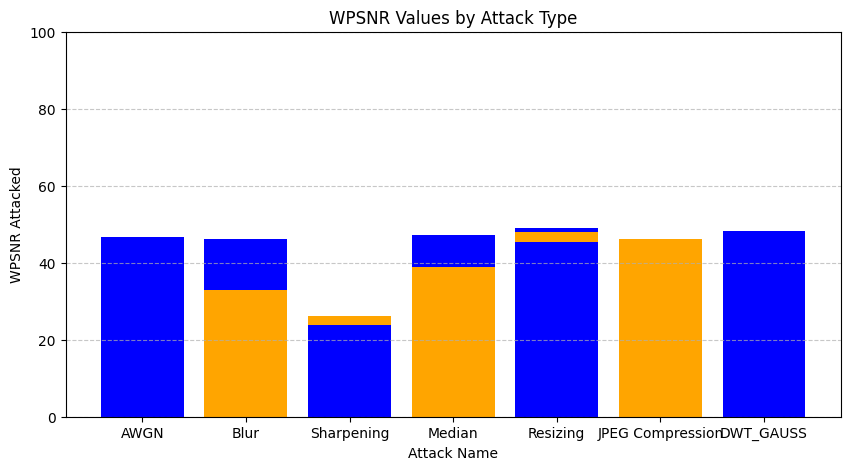

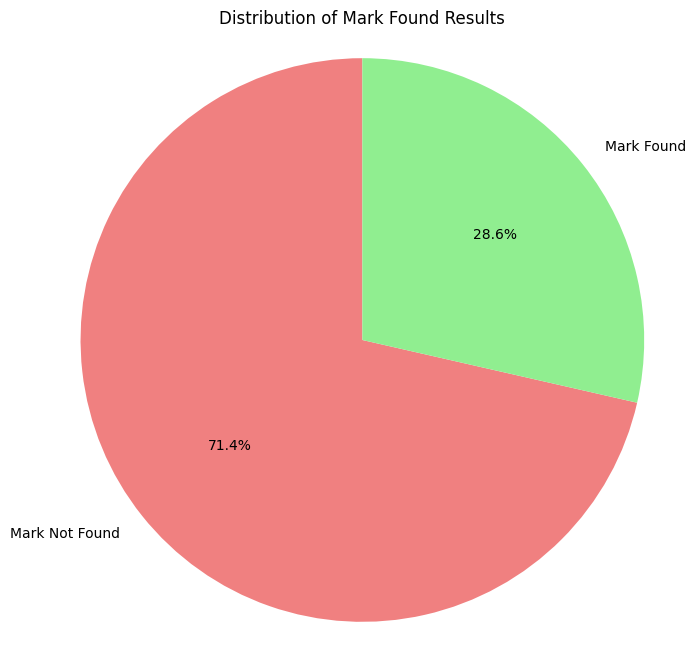

In [171]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from the CSV file
file_path = './attack_results.csv'  # Update the path if necessary
df = pd.read_csv(file_path)

# Display the DataFrame to check the loaded data (optional)
print(df)

# Bar plot for WPSNR values by Attack Name
plt.figure(figsize=(10, 5))
plt.bar(df['Attack Name'], df['WPSNR Attacked'], color=['blue', 'orange'])
plt.title('WPSNR Values by Attack Type')
plt.xlabel('Attack Name')
plt.ylabel('WPSNR Attacked')
plt.ylim(0, 100)  # Set limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Pie chart for distribution of Mark Found
mark_counts = df['Mark Found'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(mark_counts, labels=['Mark Not Found', 'Mark Found'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.title('Distribution of Mark Found Results')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


         Attack Name  WPSNR Attacked  Mark Found                  Parameters
0               AWGN       46.605446        True                      std: 2
1               AWGN       41.760256       False                     std: 10
2               AWGN       42.972902        True                      std: 8
3               AWGN       43.643029        True                      std: 7
4               AWGN       44.976788        True                      std: 5
5               Blur       36.600276       False                    sigma: 2
6               Blur       29.683316       False                    sigma: 5
7               Blur       36.600276       False                    sigma: 2
8               Blur       46.189276       False                    sigma: 1
9               Blur       32.890672       False                    sigma: 3
10        Sharpening       19.388058       False           sigma: 5 alpha: 5
11        Sharpening       19.388058       False           sigma: 5 alpha: 5

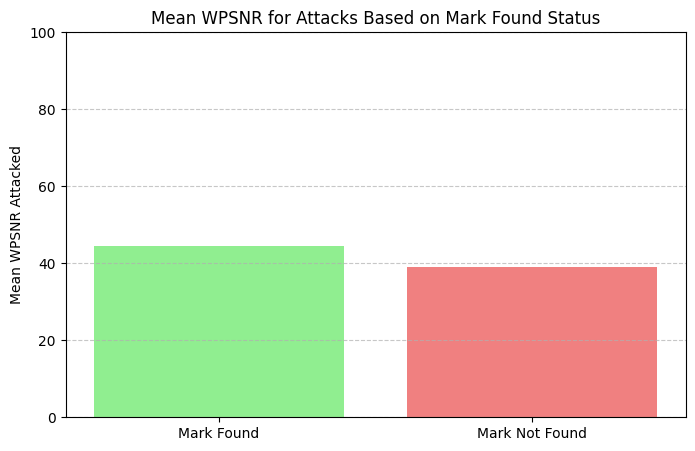

In [173]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from the CSV file
file_path = './attack_results.csv'  # Update the path if necessary
df = pd.read_csv(file_path)

# Display the DataFrame to check the loaded data (optional)
print(df)

# Calculate the mean WPSNR for cases where the mark was found and not found
mean_wpsnr_found = df[df['Mark Found'] == True]['WPSNR Attacked'].mean()
mean_wpsnr_unfound = df[df['Mark Found'] == False]['WPSNR Attacked'].mean()

# Create a bar plot for the mean WPSNR of found and unfound attacks
plt.figure(figsize=(8, 5))
plt.bar(['Mark Found', 'Mark Not Found'], [mean_wpsnr_found, mean_wpsnr_unfound], color=['lightgreen', 'lightcoral'])
plt.title('Mean WPSNR for Attacks Based on Mark Found Status')
plt.ylabel('Mean WPSNR Attacked')
plt.ylim(0, 100)  # Set limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


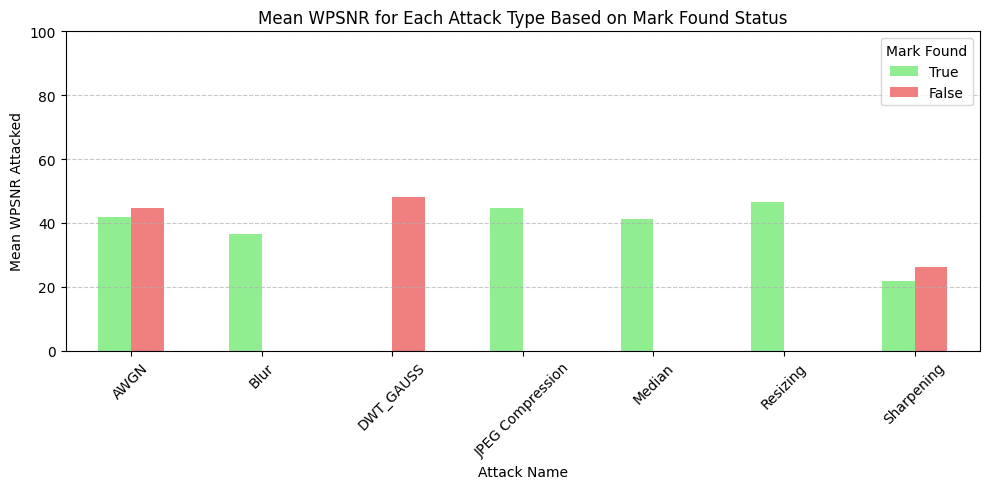

In [176]:

# Calculate mean WPSNR for each attack type based on Mark Found status
mean_wpsnr = df.groupby(['Attack Name', 'Mark Found'])['WPSNR Attacked'].mean().unstack()

# Create a bar plot for the mean WPSNR of each attack type
mean_wpsnr.plot(kind='bar', figsize=(10, 5), color=['lightgreen', 'lightcoral'])
plt.title('Mean WPSNR for Each Attack Type Based on Mark Found Status')
plt.ylabel('Mean WPSNR Attacked')
plt.xlabel('Attack Name')
plt.ylim(0, 100)  # Set limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(title='Mark Found', labels=['True', 'False'])
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

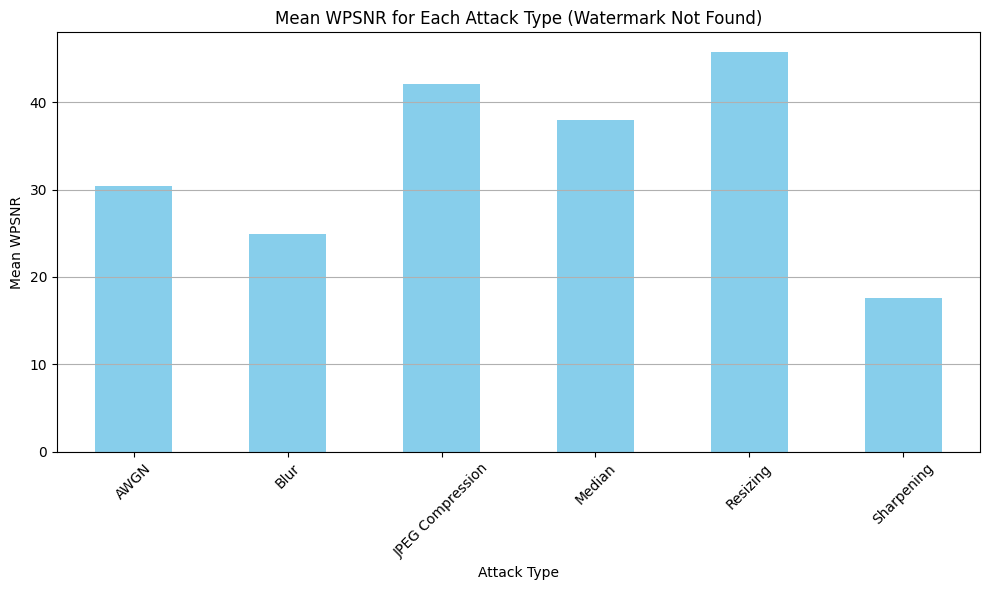

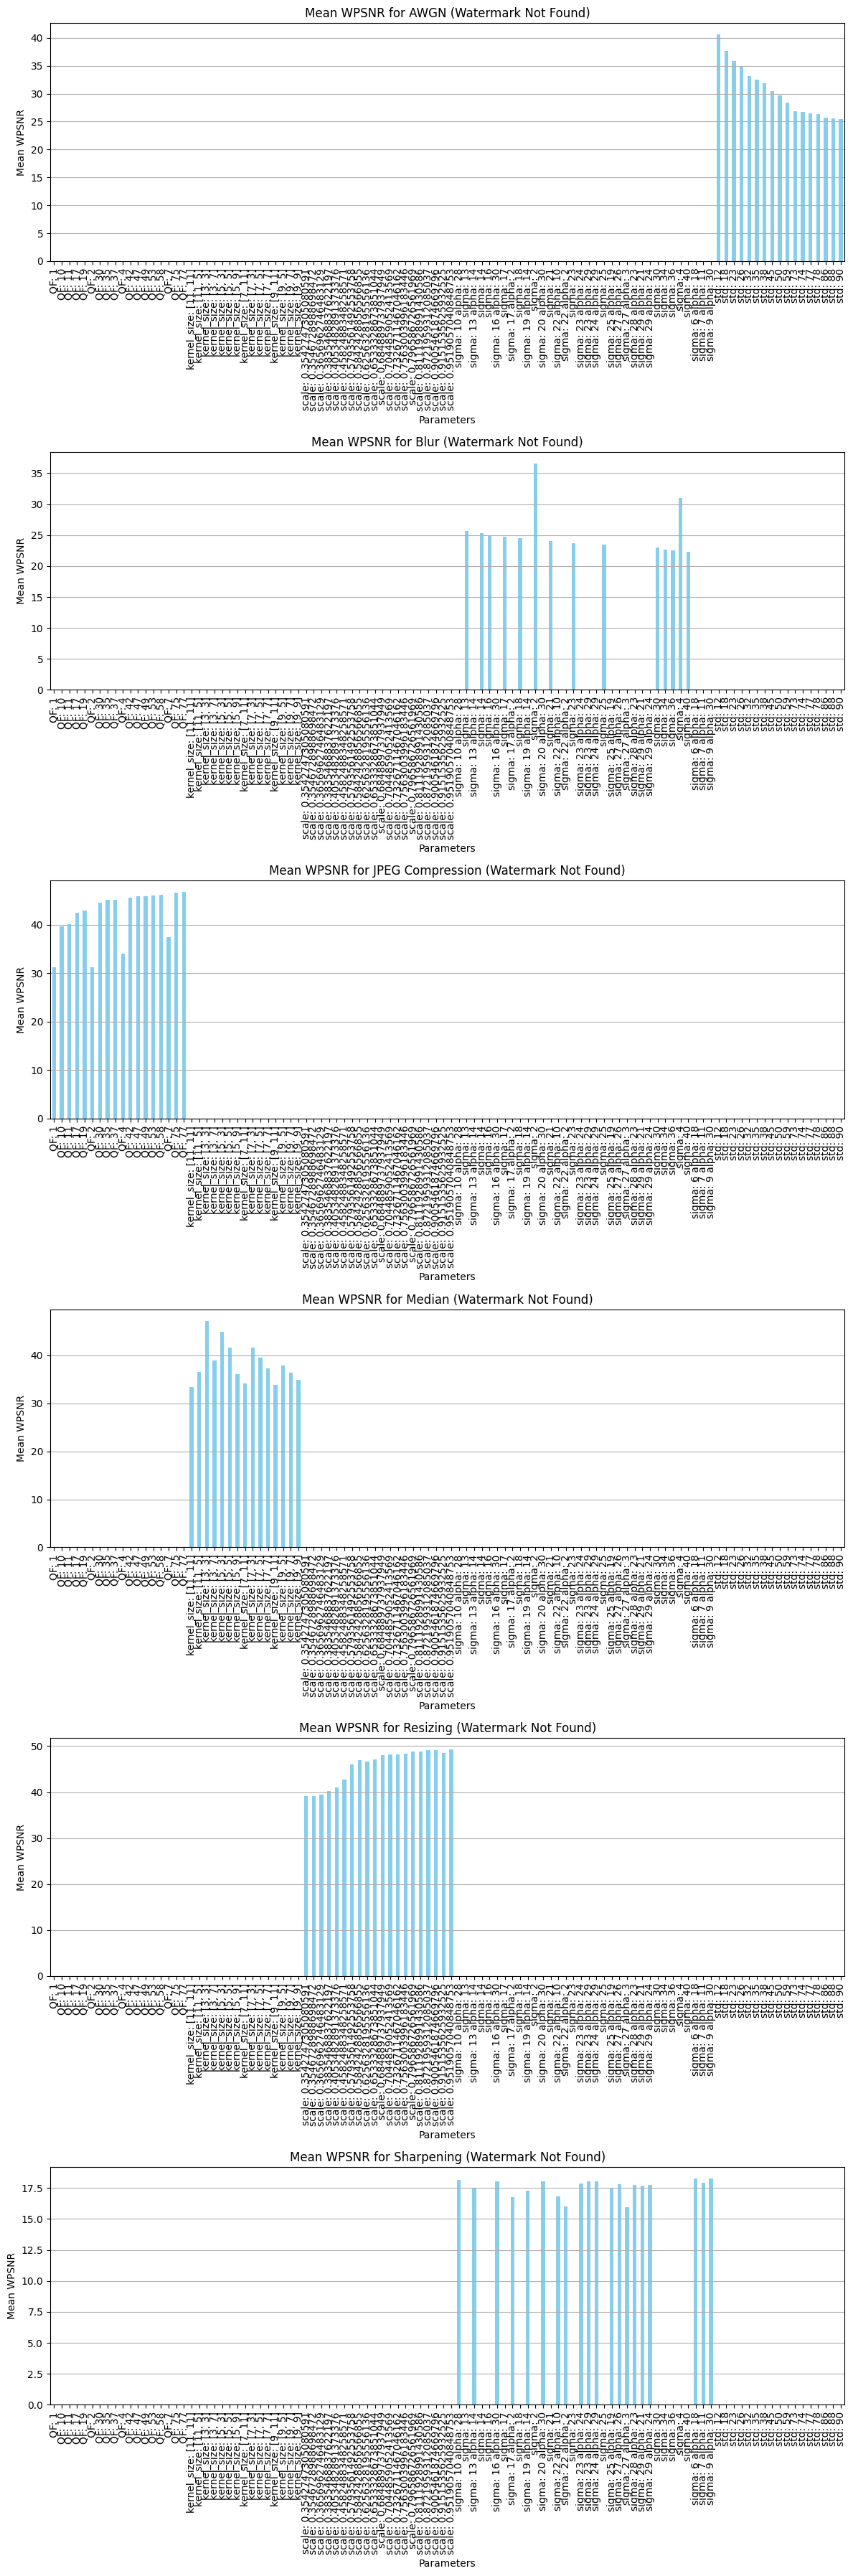

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from the CSV file
file_path = './attack_results.csv'  # Update the path if necessary
df = pd.read_csv(file_path)
# Filter data for cases where the watermark was not found
df_filtered = df[df['Mark Found'] == False]

# Group by 'Attack Name' and calculate mean WPSNR
mean_wpsnr_by_attack = df_filtered.groupby('Attack Name')['WPSNR Attacked'].mean()

# Plotting WPSNR for each attack type
plt.figure(figsize=(10, 6))
mean_wpsnr_by_attack.plot(kind='bar', color='skyblue')
plt.title('Mean WPSNR for Each Attack Type (Watermark Not Found)')
plt.xlabel('Attack Type')
plt.ylabel('Mean WPSNR')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Group by 'Attack Name' and 'Parameters' for detailed plot
# Group by 'Attack Name' and 'Parameters' for detailed plot
mean_wpsnr_by_params = df_filtered.groupby(['Attack Name', 'Parameters'])['WPSNR Attacked'].mean().unstack()

# Create subplots for each attack type
attack_names = mean_wpsnr_by_params.index
num_attacks = len(attack_names)

fig, axes = plt.subplots(nrows=num_attacks, ncols=1, figsize=(12, 6 * num_attacks))

# Plot each attack type in its own subplot with individual labels
for ax, attack in zip(axes, attack_names):
    mean_wpsnr_by_params.loc[attack].plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'Mean WPSNR for {attack} (Watermark Not Found)', fontsize=14)
    ax.set_xlabel('Parameters', fontsize=12)
    ax.set_ylabel('Mean WPSNR', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(axis='y')

plt.tight_layout()
plt.show()